In [13]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [103]:
from fastestimator.dataset import div2k
import fastestimator as fe
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import numpy as np
from fastestimator.op.numpyop import ImageReader
from fastestimator.op import TensorOp, NumpyOp

In [234]:
train_csv, val_csv,  path_div2k = div2k.load_data()

In [226]:
df = pd.read_csv(train_csv)

In [82]:
df.head()

image_hr  \
0  /home/ubuntu/fastestimator_data/DIV2K/DIV2K_tr...   
1  /home/ubuntu/fastestimator_data/DIV2K/DIV2K_tr...   
2  /home/ubuntu/fastestimator_data/DIV2K/DIV2K_tr...   
3  /home/ubuntu/fastestimator_data/DIV2K/DIV2K_tr...   
4  /home/ubuntu/fastestimator_data/DIV2K/DIV2K_tr...   

                                            image_lr  
0  /home/ubuntu/fastestimator_data/DIV2K/DIV2K_tr...  
1  /home/ubuntu/fastestimator_data/DIV2K/DIV2K_tr...  
2  /home/ubuntu/fastestimator_data/DIV2K/DIV2K_tr...  
3  /home/ubuntu/fastestimator_data/DIV2K/DIV2K_tr...  
4  /home/ubuntu/fastestimator_data/DIV2K/DIV2K_tr...

In [123]:
df = pd.read_csv(val_csv)

In [124]:
len(df)

100

In [37]:
df.head()

image_hr  \
0  /home/ubuntu/fastestimator_data/DIV2K/DIV2K_va...   
1  /home/ubuntu/fastestimator_data/DIV2K/DIV2K_va...   
2  /home/ubuntu/fastestimator_data/DIV2K/DIV2K_va...   
3  /home/ubuntu/fastestimator_data/DIV2K/DIV2K_va...   
4  /home/ubuntu/fastestimator_data/DIV2K/DIV2K_va...   

                                            image_lr  
0  /home/ubuntu/fastestimator_data/DIV2K/DIV2K_va...  
1  /home/ubuntu/fastestimator_data/DIV2K/DIV2K_va...  
2  /home/ubuntu/fastestimator_data/DIV2K/DIV2K_va...  
3  /home/ubuntu/fastestimator_data/DIV2K/DIV2K_va...  
4  /home/ubuntu/fastestimator_data/DIV2K/DIV2K_va...

In [34]:
img_path = df['image_hr'].values[0]
img = cv2.imread(img_path)
np.max(img), type(img[0][0][0])

(254, numpy.uint8)

In [228]:
height_list = []
width_list = []
for item in df['image_hr'].values:
    img = cv2.imread(item)
    height_list.append(img.shape[0])
    width_list.append(img.shape[1])

np.min(height_list), np.min(width_list)

(648, 1116)

In [229]:
648/8, 1116/8

(81.0, 139.5)

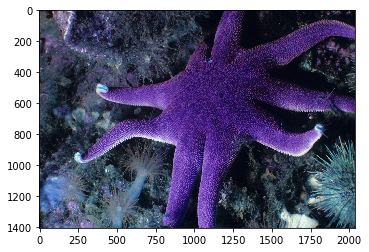

In [14]:
img = cv2.imread(df['image_hr'].values[0])
plt.imshow(img)


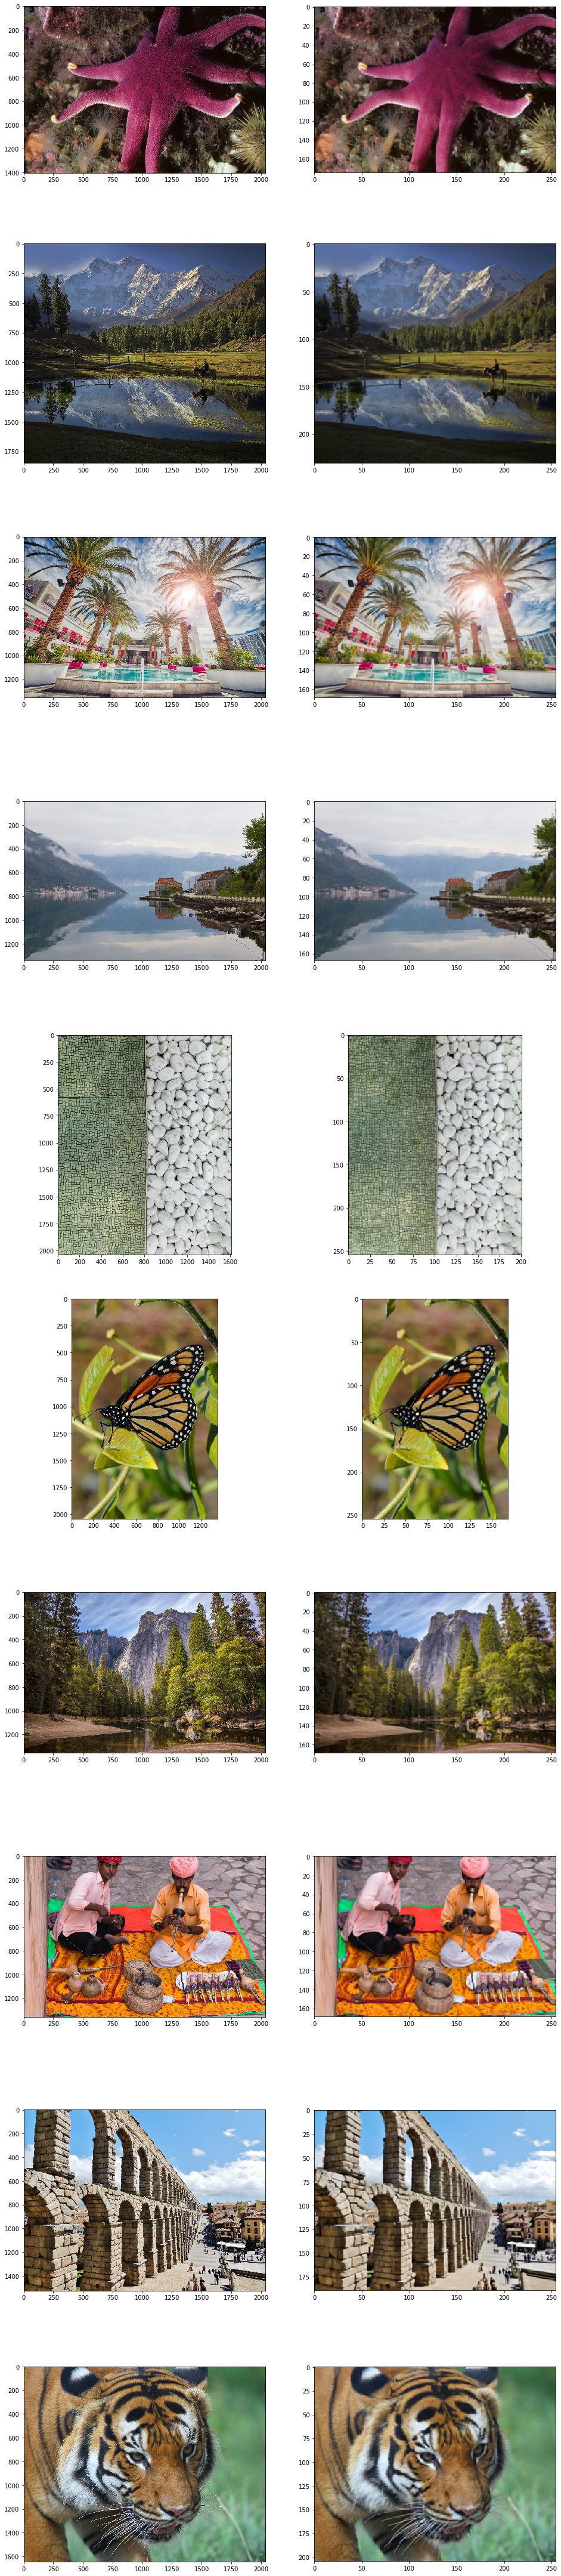

In [18]:
num_imgs_to_show = 10
start_range = 0 
end_range = start_range + num_imgs_to_show
fig, axes = plt.subplots(nrows=num_imgs_to_show,ncols=2)
fig.set_figwidth(16)
fig.set_figheight(80)
for idx,(img_hr_path, img_lr_path) in enumerate(zip(df['image_hr'].values[start_range:end_range],
                                                    df['image_lr'].values[start_range:end_range])):
    img_hr = cv2.imread(img_hr_path)
    img_hr =  cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    img_lr = cv2.imread(img_lr_path)
    img_lr =  cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    
    axes[idx][0].imshow(img_hr)
    axes[idx][1].imshow(img_lr)
plt.show()


In [187]:
class PadUptoTargetShape(NumpyOp):
    """Preprocessing class for padding the data

    Args:
        shape: target shape
    """
    def __init__(self, shape,inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.target_shape = shape

    def forward(self, data, state):
        """Pad data array

        Args:
            data: Data to be padded
            state: A dictionary containing background information such as 'mode'

        Returns:
            Padded array
        """
        input_shape = data.shape
        required_height_padding = self.target_shape[0] - input_shape[0]
        required_weight_padding = self.target_shape[1] - input_shape[1]
        pad_sequence = [(0, required_height_padding),(0, required_weight_padding),(0,0)]
        data_padded = np.pad(data,pad_sequence,mode='constant')
        return data_padded, input_shape

In [173]:
pad_sequence = [(0,2),(0,2)]
sample_array_pad = np.pad(sample_array, pad_sequence, mode='constant')

In [235]:
 writer = fe.RecordWriter(
        save_dir=os.path.join(path_div2k, "tfrecords"),
        train_data=train_csv,
        validation_data=val_csv,
        ops=[ImageReader(inputs="image_hr", outputs="image_hr"), 
             ImageReader(inputs="image_lr", outputs="image_lr"),
             PadUptoTargetShape((255,255),inputs='image_lr',outputs=['image_lr','lr_shape']),
             PadUptoTargetShape((2040,2040),inputs='image_hr',outputs=['image_hr','hr_shape'])
             ],
        compression="GZIP",
        write_feature=['image_hr', 'hr_shape', 'image_lr', 'lr_shape'])

In [198]:
class Rescale(TensorOp):
    """Rescaling data according to

    Args:
        inputs: Name of the key in the dataset that is to be filtered.
        outputs: Name of the key to be created/used in the dataset to store the results.
        mode: mode that the filter acts on.
    """
    def __init__(self, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)

    def forward(self, data, state):
        data = tf.cast(data, tf.float32)
        data /= 255
        return data

In [236]:
class RandomImagePatches(TensorOp):
    """ RandomImagePatches generates crops. These crops are defined by patch_size
    """
    def __init__(self,
                 inputs=None,
                 outputs=None,
                 mode=None,
                 hr_patch_size=(192, 192),
                 lr_patch_size=(32,32)):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.patch_size = tf.constant(patch_size, dtype=tf.dtypes.int32)

    def get_image_patch(self, image_hr, image_lr, lr_shape):
        offset_height_lr = tf.random.uniform(shape=(1, ), minval=0, 
                                          maxval= lr_shape[0]-32+1, dtype=tf.dtypes.int32)
        offset_width_lr = tf.random.uniform(shape=(1, ), minval=0, 
                                         maxval= lr_shape[1]-32+1, dtype=tf.dtypes.int32)
        crop_img_lr = image_lr[offset_height_lr[0]:offset_height_lr[0]+32, 
                               offset_width_lr[0]:offset_width_lr[0]+32]
        
        offset_height_hr = offset_height_lr[0]*8
        offset_width_hr =  offset_width_lr[0]*8
        crop_img_hr = image_hr[offset_height_hr:offset_height_hr+192, offset_width_hr:offset_width_hr+192]
        
        return crop_img_hr, crop_img_lr

    def forward(self, data, state):
        image_hr, hr_shape, image_lr, lr_shape = data
        image_hr = image_hr[0:hr_shape[0],0:hr_shape[1],:]
        image_lr = image_lr[0:lr_shape[0],0:lr_shape[1],:]
        crop_img_hr, crop_img_lr = self.get_image_patch(image_hr,image_lr, lr_shape)
        return crop_img_hr , crop_img_lr

In [237]:
pipeline = fe.Pipeline(
    batch_size=16,
    data=writer,
    ops=[RandomImagePatches(inputs=['image_hr','hr_shape','image_lr','lr_shape'], outputs=['image_hr','image_lr'])])


In [131]:
# pipeline = fe.Pipeline(
#     batch_size=16,
#     data=writer)


In [238]:
sample_batch= pipeline.show_results()

FastEstimator: Saving tfrecord to /home/ubuntu/fastestimator_data/DIV2K/tfrecords
FastEstimator: Converting Train TFRecords 0.0%, Speed: 0.00 record/sec
FastEstimator: Converting Train TFRecords 5.0%, Speed: 5.16 record/sec
FastEstimator: Converting Train TFRecords 10.0%, Speed: 5.14 record/sec
FastEstimator: Converting Train TFRecords 15.0%, Speed: 5.23 record/sec
FastEstimator: Converting Train TFRecords 20.0%, Speed: 5.12 record/sec
FastEstimator: Converting Train TFRecords 25.0%, Speed: 5.36 record/sec
FastEstimator: Converting Train TFRecords 30.0%, Speed: 5.26 record/sec
FastEstimator: Converting Train TFRecords 35.0%, Speed: 5.42 record/sec
FastEstimator: Converting Train TFRecords 40.0%, Speed: 5.26 record/sec
FastEstimator: Converting Train TFRecords 45.0%, Speed: 5.33 record/sec
FastEstimator: Converting Train TFRecords 50.0%, Speed: 5.24 record/sec
FastEstimator: Converting Train TFRecords 55.0%, Speed: 0.00 record/sec
FastEstimator: Converting Train TFRecords 60.0%, Speed: 

In [240]:
sample_batch[0].keys()

dict_keys(['image_lr', 'hr_shape', 'image_hr', 'lr_shape'])

In [241]:
image_hr = sample_batch[0]['image_hr']
image_lr = sample_batch[0]['image_lr']

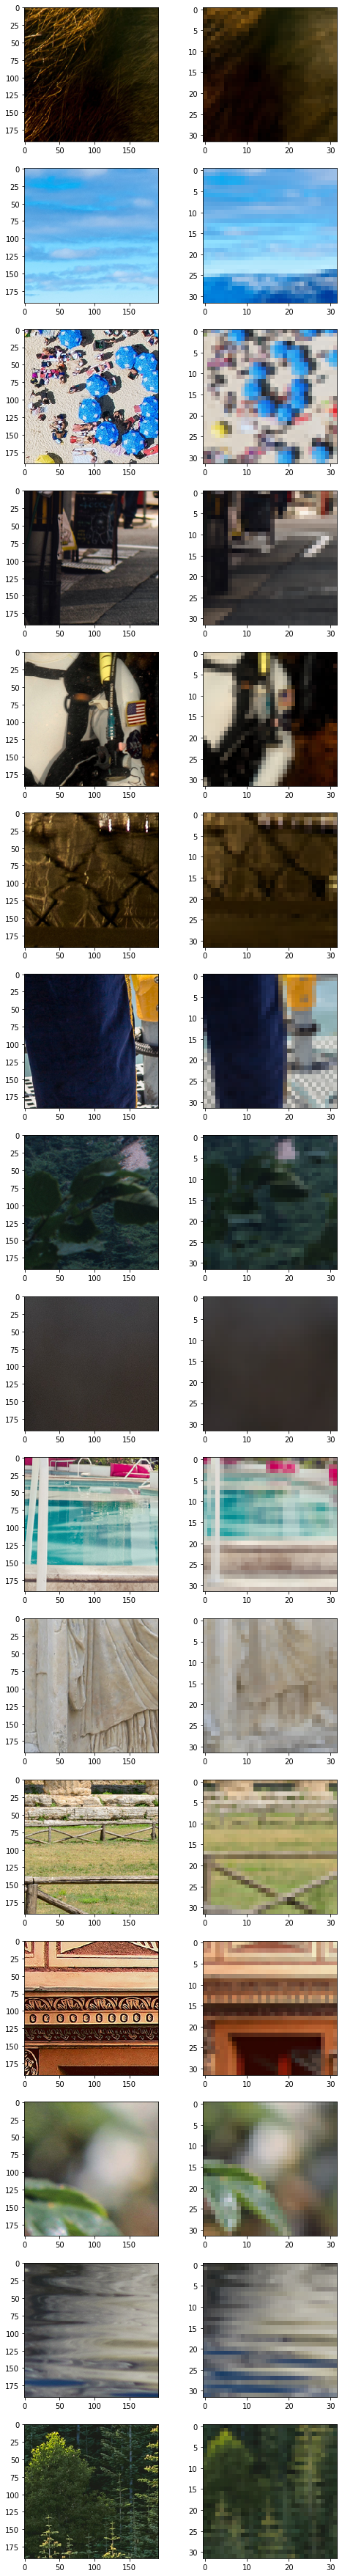

In [243]:
num_imgs_to_show = 16
fig, axes = plt.subplots(nrows=num_imgs_to_show,ncols=2)
fig.set_figwidth(8)
fig.set_figheight(64)
for idx,(img_hr, img_lr) in enumerate(zip(image_hr,image_lr)):
    axes[idx][0].imshow(img_hr)
    axes[idx][1].imshow(img_lr)
plt.show()

In [ ]:
# offset_height = tf.random.uniform(shape=(1, ), minval=0, 
#                                           maxval= hr_shape[0]-32+1, dtype=tf.dtypes.int32)
#         offset_width = tf.random.uniform(shape=(1, ), minval=0, 
#                                          maxval= hr_shape[1]-192+1, dtype=tf.dtypes.int32)
#         offset_height_hr = offset_height[0]
#         offset_width_hr =  offset_width[0]
#         crop_img_hr = image_hr[offset_height_hr:offset_height_hr+192, offset_width_hr:offset_width_hr+192]
#         offset_height_lr = offset_height[0]//8
#         offset_width_lr =  offset_width[0]//8
#         crop_img_lr = image_lr[offset_height_lr:offset_height_lr+32, 
#                                offset_width_lr:offset_width_lr+32]
#         return crop_img_hr, crop_img_lr